In [1]:
import pandas as pd
import networkx as nx
from networkx.algorithms.bipartite.basic import density
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import random

In [2]:
listenings = pd.read_csv('preprocessed_data/listenings_with_years_and_users.csv')
# we only take a look at songs released in the year 2005 and later (when the dataset begins)
listenings = listenings[listenings['year']>=2005]
# we create a unique identifier from artist and track name
listenings['art_tra_name'] = listenings['artname'] + '@' + listenings['traname']
# sort the listenings by time
listenings.sort_values(by='timestamp',inplace=True)
listenings.head()

,userid,timestamp,year,artname,traname,gender,country,art_tra_name
5794075,user_000235,2005-02-14 06:35:21+00:00,2005,The Boy Least Likely To,Be Gentle With Me,NaN,United States,The Boy Least Likely To@Be Gentle With Me
351579,user_000174,2005-02-14 10:34:54+00:00,2005,Airborn Audio,This Year,NaN,NaN,Airborn Audio@This Year
6399515,user_000575,2005-02-14 12:50:49+00:00,2008,Fall Out Boy,Tell That Mick He Just Made My List Of Things ...,m,United States,Fall Out Boy@Tell That Mick He Just Made My Li...
5797566,user_000235,2005-02-14 17:56:23+00:00,2005,Bright Eyes,When The President Talks To God,NaN,United States,Bright Eyes@When The President Talks To God
5797565,user_000235,2005-02-14 18:06:14+00:00,2005,Bright Eyes,When The President Talks To God,NaN,United States,Bright Eyes@When The President Talks To God


When we look at the degree distribution we can clearly see the typical preferential attachment pattern.

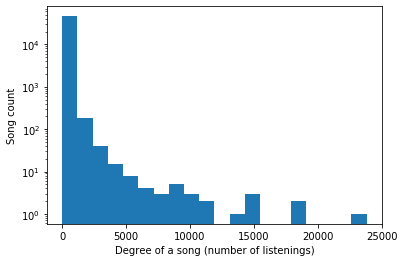

In [3]:
# log scaled degree distribution for songs 

G = nx.MultiGraph()
G.add_nodes_from(listenings['userid'], isSong=False)
G.add_nodes_from(listenings['art_tra_name'], isSong=True)
G.add_edges_from(list(zip(listenings['userid'],listenings['art_tra_name'])),time = listenings['timestamp'])
songDegrees = [G.degree(n) for n,data in G.nodes(data=True) if data['isSong']==True]
plt.hist(songDegrees, bins=20)
plt.xlabel('Degree of a song (number of listenings)')
plt.ylabel('Song count')
plt.yscale('log', nonposy='clip')
plt.show()

We have created a custom metric to express the intensity of preferential attachment phenomena in the data. We loop over the listenings data ordered by the timestamp. At each step we calculate the random probability (1 divided by total number of songs that appeared so far) and popularity weighted probability (number of songs listenings so far divided by total nunmber of listenings of all songs so far). At the end we compara the sums of these probabilities. If the weighted probability was higher it means the preferential attachment has an influence, if the values are the same songs popularity has no effect, if the weighted is lower then users tend to favour unpopular songs. This method makes use of the precise timestamp information since the song popularities are different at each point in time. Another advantage is it naturally deals with the fact that the number of distinct users in the dataset is rising over time.

In [4]:
def pref_attach_intensity(listenings,attrName='art_tra_name',attrFilter=None):
    listenCntsDict = {} #  song_name -> song_listen_count
    listenCntSum = 0 
    randomProbList = []
    popularityWeightedProbList = []

    for name,attr in tqdm(zip(listenings['art_tra_name'],listenings[attrName]),total=len(listenings),
                                                     position=0, leave=True):
        # if the song was already listened to at least once
        if (name in listenCntsDict):
            # optional filter using datasets user attributes
            if(attrName=='art_tra_name' or attr==attrFilter):
                # completely random probability
                randomProb = 1/len(listenCntsDict)
                # probability proportional to the number of listenings of the song
                popularityWeightedProb = listenCntsDict[name] / listenCntSum

                randomProbList.append(randomProb)
                popularityWeightedProbList.append(popularityWeightedProb)
            
            listenCntsDict[name] += 1
        # if this is the first time the song is being listened to
        else:
            listenCntsDict[name] = 1

        listenCntSum += 1
    
    return sum(popularityWeightedProbList)/sum(randomProbList)

We test the method on artificial dummy data. We generate 1 million of random song listenings of 1000 distinct songs. As mentioned before, if the preferential attachment is not present in the data the value should be close to 1 which is the case here.

In [5]:
random.seed(0)
N_DISTINCT_SONGS = 1000
N_LISTENINGS = 1000000

artTraNameTest = [random.randint(1,N_DISTINCT_SONGS) for x in range(N_LISTENINGS)]
testDf = pd.DataFrame()
testDf['art_tra_name'] = artTraNameTest
testDf.head()

,art_tra_name
0,865
1,395
2,777
3,912
4,431


In [6]:
pref_attach_intensity(testDf)

100%|██████████| 1000000/1000000 [00:00<00:00, 1016661.72it/s]


0.9999717900756318

We calculate the value for the real data, we can see the preferential attachment is a strong phenomenon in this dataset.

In [7]:
pref_attach_intensity(listenings)

100%|██████████| 2608553/2608553 [00:02<00:00, 879187.40it/s]


17.146693879347005

# Comparing preferential attachment for subsets of the dataset based on the attributes

## User's gender

When we calculate the values for different genders in the data we can see we get a slightly bigger results for males.

In [8]:
pref_attach_intensity(listenings,'gender','m')

100%|██████████| 2608553/2608553 [00:02<00:00, 998398.18it/s] 


19.271931627232917

In [9]:
pref_attach_intensity(listenings,'gender','f')

100%|██████████| 2608553/2608553 [00:02<00:00, 1064168.70it/s]


16.70880603462174

## User's geographical area

In [10]:
europeList = ['United Kingdom', 'Finland', 'Germany', 'Sweden', 'Canada', 'Switzerland',
    'Norway', 'Poland', 'Netherlands', 'Belgium', 'Italy', 'Romania',
       'Russian Federation', 'Spain',
       'Ireland','Czech Republic','France', 'China',
       'Austria', 'Slovakia', 'Malta',
       'Latvia', 'Estonia', 'Lithuania',
      'Iceland', 'Bulgaria',
      'Portugal', 'Croatia',  'Serbia', 'Greece', 'Hungary',
       'Bosnia and Herzegovina', 'Slovenia',
       'Belarus',  'Macedonia']

In [11]:
# we rename the European countries so that we have a bigger geographical group which we can compare to the United States
listenings['country'] = listenings['country'].apply(lambda x: 'Europe' if x in europeList else x)

There is almost no difference between the values for users from these two different geographical areas.

In [12]:
pref_attach_intensity(listenings,'country','United States')

100%|██████████| 2608553/2608553 [00:02<00:00, 1106909.72it/s]


12.190982020220163

In [13]:
pref_attach_intensity(listenings,'country','Europe')

100%|██████████| 2608553/2608553 [00:02<00:00, 1014689.52it/s]


13.468441136341436

## Song genres

In [14]:
listeningsWithTags = pd.read_csv('preprocessed_data/listenings_with_years_and_tags.csv')
listeningsWithTags = listeningsWithTags[listeningsWithTags['year']>=2005]
listeningsWithTags['art_tra_name'] = listeningsWithTags['artname'] + '@' + listeningsWithTags['traname']
listeningsWithTags.sort_values(by='timestamp',inplace=True)
listeningsWithTags.head()

,userid,timestamp,tid,tag,year,artname,traname,art_tra_name
1022218,user_000235,2005-02-14 06:35:21+00:00,TRIUULX128F146EC75,indie,2005,The Boy Least Likely To,Be Gentle With Me,The Boy Least Likely To@Be Gentle With Me
5142905,user_000575,2005-02-14 12:50:49+00:00,TRPVVWW128F42385E3,rock,2008,Fall Out Boy,Tell That Mick He Just Made My List Of Things ...,Fall Out Boy@Tell That Mick He Just Made My Li...
4443361,user_000235,2005-02-14 17:56:23+00:00,TRMYXPN128F149798D,indie,2005,Bright Eyes,When The President Talks To God,Bright Eyes@When The President Talks To God
4443360,user_000235,2005-02-14 18:06:14+00:00,TRMYXPN128F149798D,indie,2005,Bright Eyes,When The President Talks To God,Bright Eyes@When The President Talks To God
4443359,user_000235,2005-02-14 18:16:05+00:00,TRMYXPN128F149798D,indie,2005,Bright Eyes,When The President Talks To God,Bright Eyes@When The President Talks To God


In [15]:
listeningsWithTags['tag'].unique()

array(['indie', 'rock', 'alternative', 'electronic', 'pop'], dtype=object)

In [16]:
intensities = []
for tag in listeningsWithTags['tag'].unique():
    intensities.append(pref_attach_intensity(listeningsWithTags[listeningsWithTags['tag']==tag]))

100%|██████████| 447231/447231 [00:00<00:00, 938955.03it/s]


Looking at the results differentiated by songs genre we can clearly see pop genre stands out from the others. Intuitively this is not so surprising as pop music fans are usually the ones that listen to songs which are popular.

<BarContainer object of 5 artists>

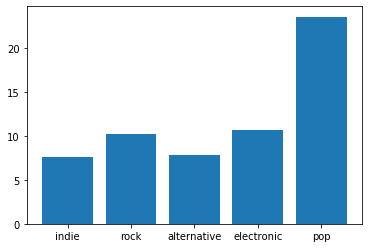

In [17]:
plt.bar(x=listeningsWithTags['tag'].unique(), height=intensities)